In [1]:
import pandas as pd
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [2]:
data_df = pd.read_csv("./data/input/train.csv")
data_df.drop(columns=['uuid', 'title', 'author', 'Keywords'], inplace=True, axis=1)
print(data_df.shape)

(6000, 2)


In [3]:
def tokenize_dataframe(row):
    row['tokenized'] = nltk.tokenize.word_tokenize(row['abstract'])
    return row

data_df['tokenized'] = [list() for _ in range(data_df.shape[0])]
data_df = data_df.apply(tokenize_dataframe, axis=1)

In [4]:
lemmatizer = WordNetLemmatizer()

In [5]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [6]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [7]:
import re
import numpy as np

do_remove_punct = True
do_lemmatize = True
do_lowercase = True
do_remove_stop = True
do_remove_nums = True

def custom_tokenize(row):
    text = row['abstract']
    
    # 01 - Punctuations
    if do_remove_punct:
        text = re.sub(r'([^\w\s])', ' ', text)

    # 02 - Lemmatization
    if do_lemmatize:
        tokens_list = nltk.word_tokenize(text)
        text = ' '.join([lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in tokens_list])

    # 03 - Lowercasing
    if do_lowercase:
        text = text.lower()

    # 04 - Removing stop words (i.e. grammar defining words, not adding value to main topic)
    if do_remove_stop:
        text = ' '.join([t for t in text.split() if t not in stopwords])

    # 05 - Removing numbers
    if do_remove_nums:
        text = re.sub(r'\b[0-9]+\b', ' ', text)

    # Removing redundant spaces
    text = re.sub(r' +', ' ', text)

    row['custom_tokenized'] = text.split()
    return row

data_df['custom_tokenized'] = [list() for _ in range(data_df.shape[0])]
data_df = data_df.apply(custom_tokenize, axis=1)

data_df.head(20)

,abstract,label,tokenized,custom_tokenized
0,Despite the use of tactile graphics and audio ...,0,"[Despite, the, use, of, tactile, graphics, and...","[despite, use, tactile, graphic, audio, guide,..."
1,"During the past two decades, epileptic seizure...",1,"[During, the, past, two, decades, ,, epileptic...","[past, two, decade, epileptic, seizure, detect..."
2,Lymph node metastasis is one of the most impor...,1,"[Lymph, node, metastasis, is, one, of, the, mo...","[lymph, node, metastasis, one, important, indi..."
3,In order to assess the effectiveness of the Ch...,0,"[In, order, to, assess, the, effectiveness, of...","[order, ass, effectiveness, chinese, governmen..."
4,Convolutional Neural Networks (CNNs) have beco...,0,"[Convolutional, Neural, Networks, (, CNNs, ), ...","[convolutional, neural, networks, cnns, become..."
5,Previously we showed the generation of a prote...,1,"[Previously, we, showed, the, generation, of, ...","[previously, show, generation, protein, trap, ..."
6,Facial emotion recognition (FER) is a field of...,0,"[Facial, emotion, recognition, (, FER, ), is, ...","[facial, emotion, recognition, fer, field, res..."
7,This paper proposes a machine learning model b...,0,"[This, paper, proposes, a, machine, learning, ...","[paper, proposes, machine, learn, model, base,..."
8,Most current state-of-the-art blind image qual...,0,"[Most, current, state-of-the-art, blind, image...","[current, state, art, blind, image, quality, a..."
9,Surgical workflow recognition has numerous pot...,1,"[Surgical, workflow, recognition, has, numerou...","[surgical, workflow, recognition, numerous, po..."


In [8]:
from scipy.stats import entropy
from collections import Counter, defaultdict

do_remove_entropy = True
max_entropy = 0.5

entropy_dict = defaultdict()
token_labels_cnt = defaultdict()

def find_token_entropies(token, base=None):
    # Find entropies of each token wrt labels
    # token_labels_cnt = Dictionary which states how many times `token` comes with labels 0 and 1
    global entropy_dict

    try:
        token_labels = [0]*token_labels_cnt[token][0] + [1]*token_labels_cnt[token][1]
        value, counts = np.unique(token_labels, return_counts=True)
        entropy_dict[token] = entropy(counts, base=base)
    except:
        entropy_dict[token] = 100

def find_token_label_cnts(row):
    # Find how many times a token comes with labels 0 and 1
    global token_labels_cnt
    
    tokens = row['custom_tokenized']
    label = row['label']

    for token in tokens:
        if token not in token_labels_cnt.keys():
            token_labels_cnt[token] = {0:0, 1:0}

        # Increment the counter of token belonging to label by 1
        token_labels_cnt[token][label] += 1

    return row

data_df = data_df.apply(find_token_label_cnts, axis=1)


def remove_high_entropy_tokens(row):
    # Removing tokens with high entropies
    tokens = row['custom_tokenized']
    row['custom_tokenized'] = [token for token in tokens if entropy_dict[token]<max_entropy]
    return row

if do_remove_entropy:
    for token in token_labels_cnt.keys():
        find_token_entropies(token)
        
    data_df = data_df.apply(remove_high_entropy_tokens, axis=1)

In [9]:
token_labels_cnt

defaultdict(None,
            {'despite': {0: 90, 1: 131},
             'use': {0: 2934, 1: 2493},
             'tactile': {0: 13, 1: 14},
             'graphic': {0: 72, 1: 5},
             'audio': {0: 102, 1: 3},
             'guide': {0: 116, 1: 131},
             'blind': {0: 38, 1: 16},
             'visually': {0: 32, 1: 7},
             'impaired': {0: 17, 1: 39},
             'people': {0: 173, 1: 128},
             'still': {0: 208, 1: 161},
             'face': {0: 359, 1: 109},
             'challenge': {0: 706, 1: 467},
             'experience': {0: 139, 1: 143},
             'understand': {0: 193, 1: 302},
             'visual': {0: 396, 1: 149},
             'artwork': {0: 74, 1: 0},
             'independently': {0: 25, 1: 23},
             'art': {0: 6582, 1: 598},
             'exhibition': {0: 35, 1: 0},
             'museum': {0: 113, 1: 1},
             'place': {0: 106, 1: 66},
             'increasingly': {0: 56, 1: 55},
             'explore': {0: 195, 1: 243},

In [10]:
data_df

,abstract,label,tokenized,custom_tokenized
0,Despite the use of tactile graphics and audio ...,0,"[Despite, the, use, of, tactile, graphics, and...","[graphic, audio, visually, artwork, art, exhib..."
1,"During the past two decades, epileptic seizure...",1,"[During, the, past, two, decades, ,, epileptic...","[epileptic, seizure, algorithm, hardware, area..."
2,Lymph node metastasis is one of the most impor...,1,"[Lymph, node, metastasis, is, one, of, the, mo...","[lymph, metastasis, breast, cancer, diagnosis,..."
3,In order to assess the effectiveness of the Ch...,0,"[In, order, to, assess, the, effectiveness, of...","[cohort, adult, patient, shenzhen, antiretrovi..."
4,Convolutional Neural Networks (CNNs) have beco...,0,"[Convolutional, Neural, Networks, (, CNNs, ), ...","[networks, state, art, vision, recognition, co..."
...,...,...,...,...
5995,"Phase change memory (PCM) is an emerging, resi...",0,"[Phase, change, memory, (, PCM, ), is, an, eme...","[pcm, resistance, nonvolatile, pcm, pcm, write..."
5996,Oxy-fuel combustion stands as a promising carb...,0,"[Oxy-fuel, combustion, stands, as, a, promisin...","[oxy, layout, oxy, paper, state, art, oxy, oxy..."
5997,This study aims to establish an efficient pret...,1,"[This, study, aims, to, establish, an, efficie...","[sugar, macroalgae, eucheuma, cottonii, residu..."
5998,Pseudomonas aeruginosa is an opportunistic pat...,1,"[Pseudomonas, aeruginosa, is, an, opportunisti...","[pseudomonas, aeruginosa, pathogen, acute, chr..."


## TF-IDF Vectorizer

### Some illustrations before we dive deep

In [11]:
corpus_demo = [
    'yesterday massive internet blackout was reported across the region',
    'all the internet providers except xyz corp faced issues in network traffic',
    'the internet downtime that lasted for about 12 hours brought almost everything to halt',
    'all the 91 metro stations saw huge crowd bottleneck as ticketing systems got impacted as they were not on xyz corp internet system',
    'the internet outage however motivated people to throng to gardens and open spaces and enjoy nature',
    'all the impacted internet providers were working on war footing',
    'meanwhile xyz corp was quick enough to scale the service and incorporate impacted essential entities like public transit government corporates on their internet network on urgent basis',
    'businesses started functioning as soon as xyz corp services were provisioned but the general people were still waiting for internet network to be back on their devices',
    'after a long investigation of 12 hrs it was found that their common supply internet cable was bitten and cut by mouse',
    'it is worth noting that all internet providers except xyz corp use low quality wires whereas xyz corp uses high grade optic fibre cables and is around 5x expensive than others'
]

In [12]:
from collections import Counter
import math

def calculate_tf(token, document):
    return Counter(document.split())[token]

def calculate_idf(token):
    total_docs = len(corpus_demo)
    count_of_token_in_corpus = Counter(word for doc in corpus_demo for word in set(doc.split()) if word==token)[token]
    idf = math.log(total_docs / float(count_of_token_in_corpus))
    return idf

def calculate_tfidf(token, document):
    return calculate_tf(token, document)*calculate_idf(token)

In [13]:
print(calculate_tf('internet', corpus_demo[0]))
print(calculate_tf('xyz', corpus_demo[-1]))
print(calculate_tf('bottleneck', corpus_demo[3]))

1
2
1


In [14]:
print(calculate_idf('internet'))
print(calculate_idf('xyz'))
print(calculate_idf('bottleneck'))

0.0
0.6931471805599453
2.302585092994046


In [15]:
print(calculate_tfidf('internet', corpus_demo[0]))
print(calculate_tfidf('xyz', corpus_demo[-1]))
print(calculate_tfidf('bottleneck', corpus_demo[3]))
print(calculate_tfidf('bottleneck', corpus_demo[0]))

0.0
1.3862943611198906
2.302585092994046
0.0


### TF-IDF is like a beam balance between TF and IDF

### Coming to actual data

In [129]:
corpus = data_df['custom_tokenized'].tolist()

In [1]:
# corpus

#### Need to convert `corpus` to list of tokenized documents let's say `corpus_docs`
#### Instead of the current nested list of tokens

In [131]:
corpus_docs = list()
for tokenized_doc in corpus:
    tokenized_doc = ' '.join([token for token in tokenized_doc])
    corpus_docs.append(tokenized_doc)

In [2]:
# corpus[0]

In [133]:
len(corpus_docs)

6000

In [134]:
# corpus_docs is thus a list of documents
# Unlike corpus which was a list of list of words belonging to those documents
corpus_docs[0]

'graphic audio visually artwork art exhibition art museum art audio autonomous artwork artwork audio listen music formative visually art museum gallery artist formative art exhibition graphic artwork'

In [135]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                   ngram_range=(1,1),
                                   min_df=0.0,          # Features should occur in minimum this much proportion of documents
                                   max_df=1.0          # Features should occur in at the max this much proportion of documents
                                  )

In [136]:
tfidf_vectorizer

TfidfVectorizer(min_df=0.0)

In [137]:
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

### How does it look like?

In [138]:
tfidf_matrix

<6000x28149 sparse matrix of type '<class 'numpy.float64'>'
	with 118778 stored elements in Compressed Sparse Row format>

In [139]:
tfidf_matrix[0]

<1x28149 sparse matrix of type '<class 'numpy.float64'>'
	with 13 stored elements in Compressed Sparse Row format>

In [140]:
print(tfidf_matrix[0])

  (0, 2035)	0.12341166134591416
  (0, 9981)	0.14443034592069584
  (0, 9644)	0.3809648354569211
  (0, 16576)	0.13737775328994836
  (0, 14346)	0.17171784987357605
  (0, 2347)	0.12104261771939048
  (0, 16574)	0.2537703039989986
  (0, 8885)	0.28531538176886917
  (0, 1997)	0.16824156547014754
  (0, 2045)	0.5324696603995912
  (0, 27250)	0.27752470389700484
  (0, 2275)	0.3930199231501406
  (0, 10617)	0.25815931063621517


In [141]:
print(tfidf_feature_names)
print(type(tfidf_feature_names))

['00l' '03ni0' '03ti0' ... 'ω8c' 'ω9c' 'нeр']
<class 'numpy.ndarray'>


### Saving the TF-IDF Matrix

In [142]:
tfidf_matrix_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)
# tfidf_matrix_df.to_csv('./data/output/tfidf_matrix_df.csv')

In [145]:
tfidf_matrix_df

,00l,03ni0,03ti0,05nm,05x,06942t,0e7,0g,0h,0th,...,μn,μpa2,μt,τc,χ2,ω6c,ω7c,ω8c,ω9c,нeр
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Let's see TF-IDF profile of useless feature '0000'

In [146]:
tfidf_matrix_df['00l'].value_counts()

00l
0.000000    5999
0.122954       1
Name: count, dtype: int64

In [147]:
# import numpy as np

# features = [" ".join(tfidf_feature_names[np.flatnonzero(row)]) for row in tfidf_matrix.todense()]
# tfidf_ranked_features_df = pd.DataFrame({"corpus_doc": corpus_docs, "ranked_tfidf_features": features})
# # tfidf_ranked_features_df.to_csv('./data/output/tfidf_ranked_features_df.csv')

# print(tfidf_ranked_features_df.head(10))
# del tfidf_ranked_features_df

### Let's Vizualise
#### Document-wise vizualisation

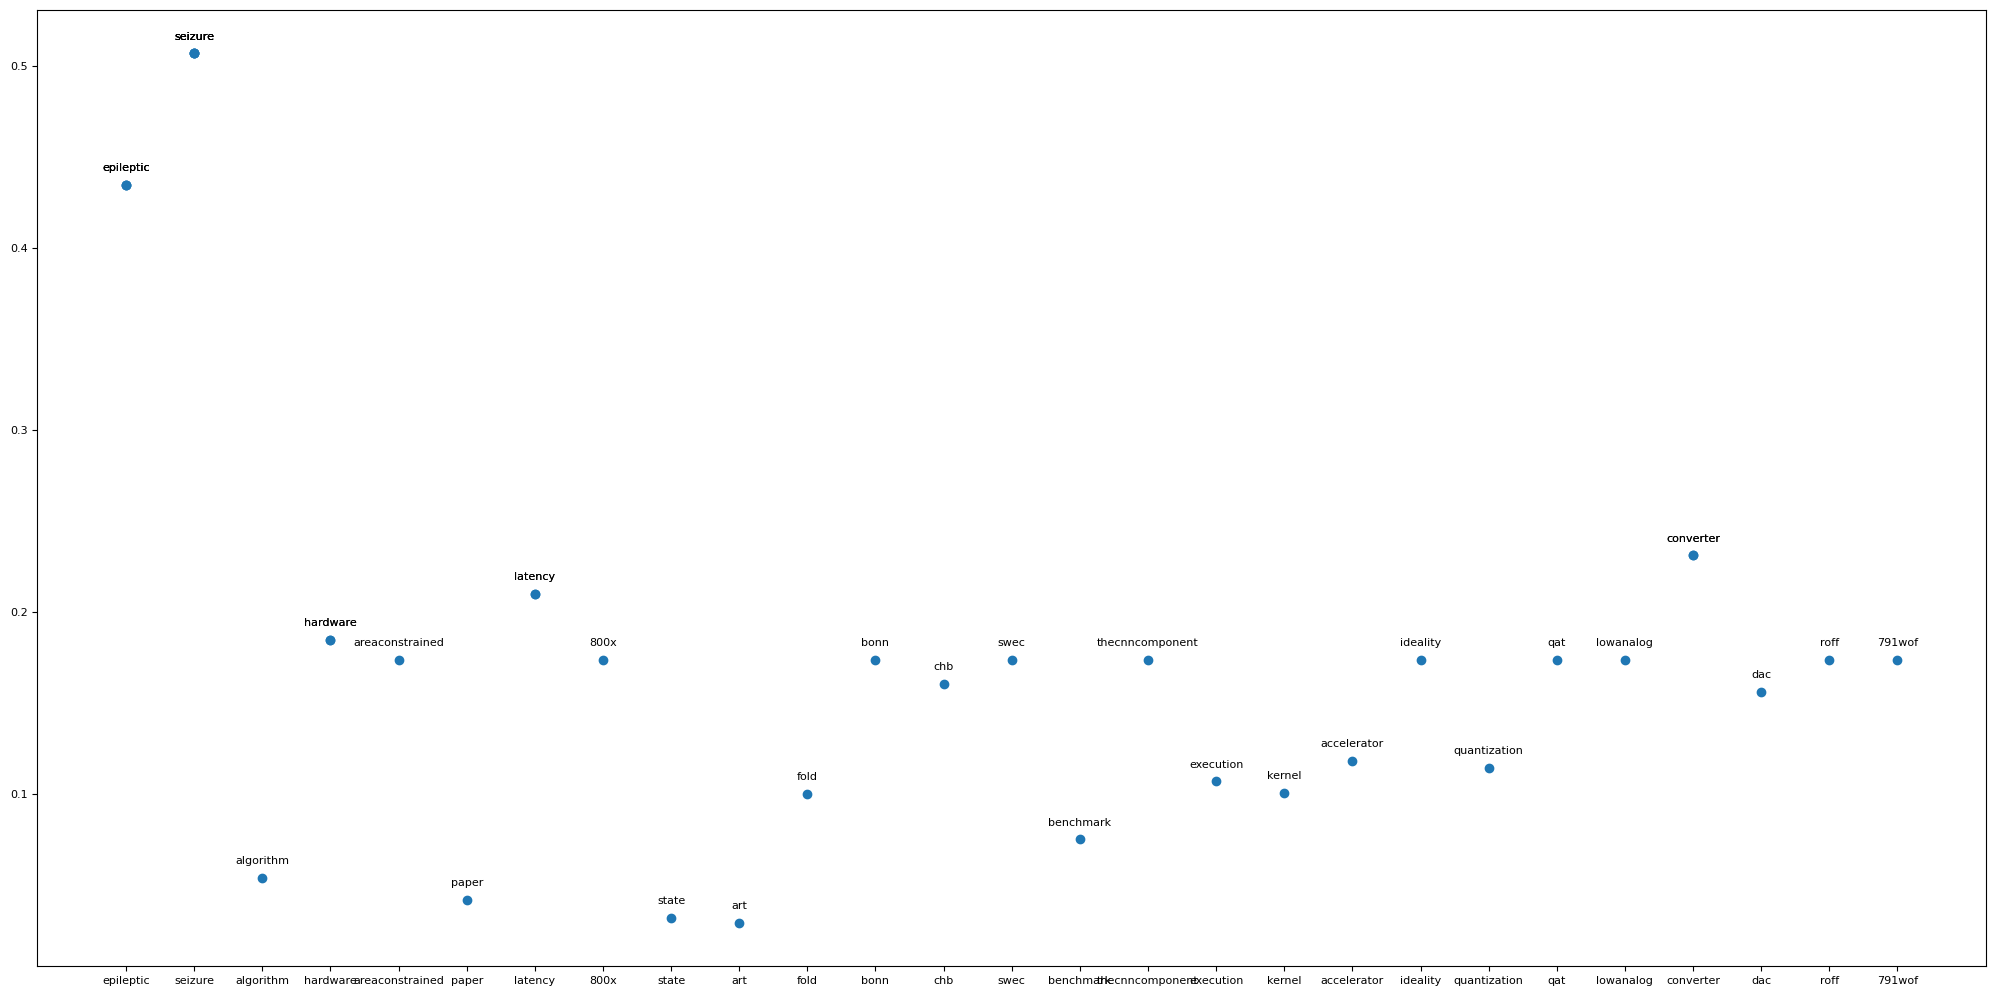

In [162]:
import matplotlib.pyplot as plt

# Index of document to vizualize TF-IDF
idx_doc = 1

plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["font.size"] = 8

doc = corpus[idx_doc]
doc = [token for token in doc if token in tfidf_matrix_df.columns]     # This is to handle - Certain tokens getting eliminated

tfidf_scores = [tfidf_matrix_df.iloc[idx_doc][token] for token in doc if token in tfidf_matrix_df.columns]
plt.scatter(doc, tfidf_scores)

labels = doc
for i, label in enumerate(labels):
    plt.annotate(label, # this is the text
                 (doc[i], tfidf_scores[i]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

### As seen, variation in TF-IDF scores is not too high
### Thus, moreover all tokens are getting similar weights in nearly all documents

### Let's play around

In [253]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                   ngram_range=(1,1),
                                   min_df=20,          # Features should occur in minimum this much number of documents
                                   max_df=0.8          # Features should occur in at the max this much proportion of documents
                                  )

In [254]:
tfidf_vectorizer

TfidfVectorizer(max_df=0.8, min_df=20)

In [255]:
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

### How does it look like?

In [256]:
tfidf_matrix

<6000x883 sparse matrix of type '<class 'numpy.float64'>'
	with 63902 stored elements in Compressed Sparse Row format>

In [257]:
tfidf_matrix[0]

<1x883 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [3]:
# tfidf_feature_names

In [259]:
tfidf_matrix_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

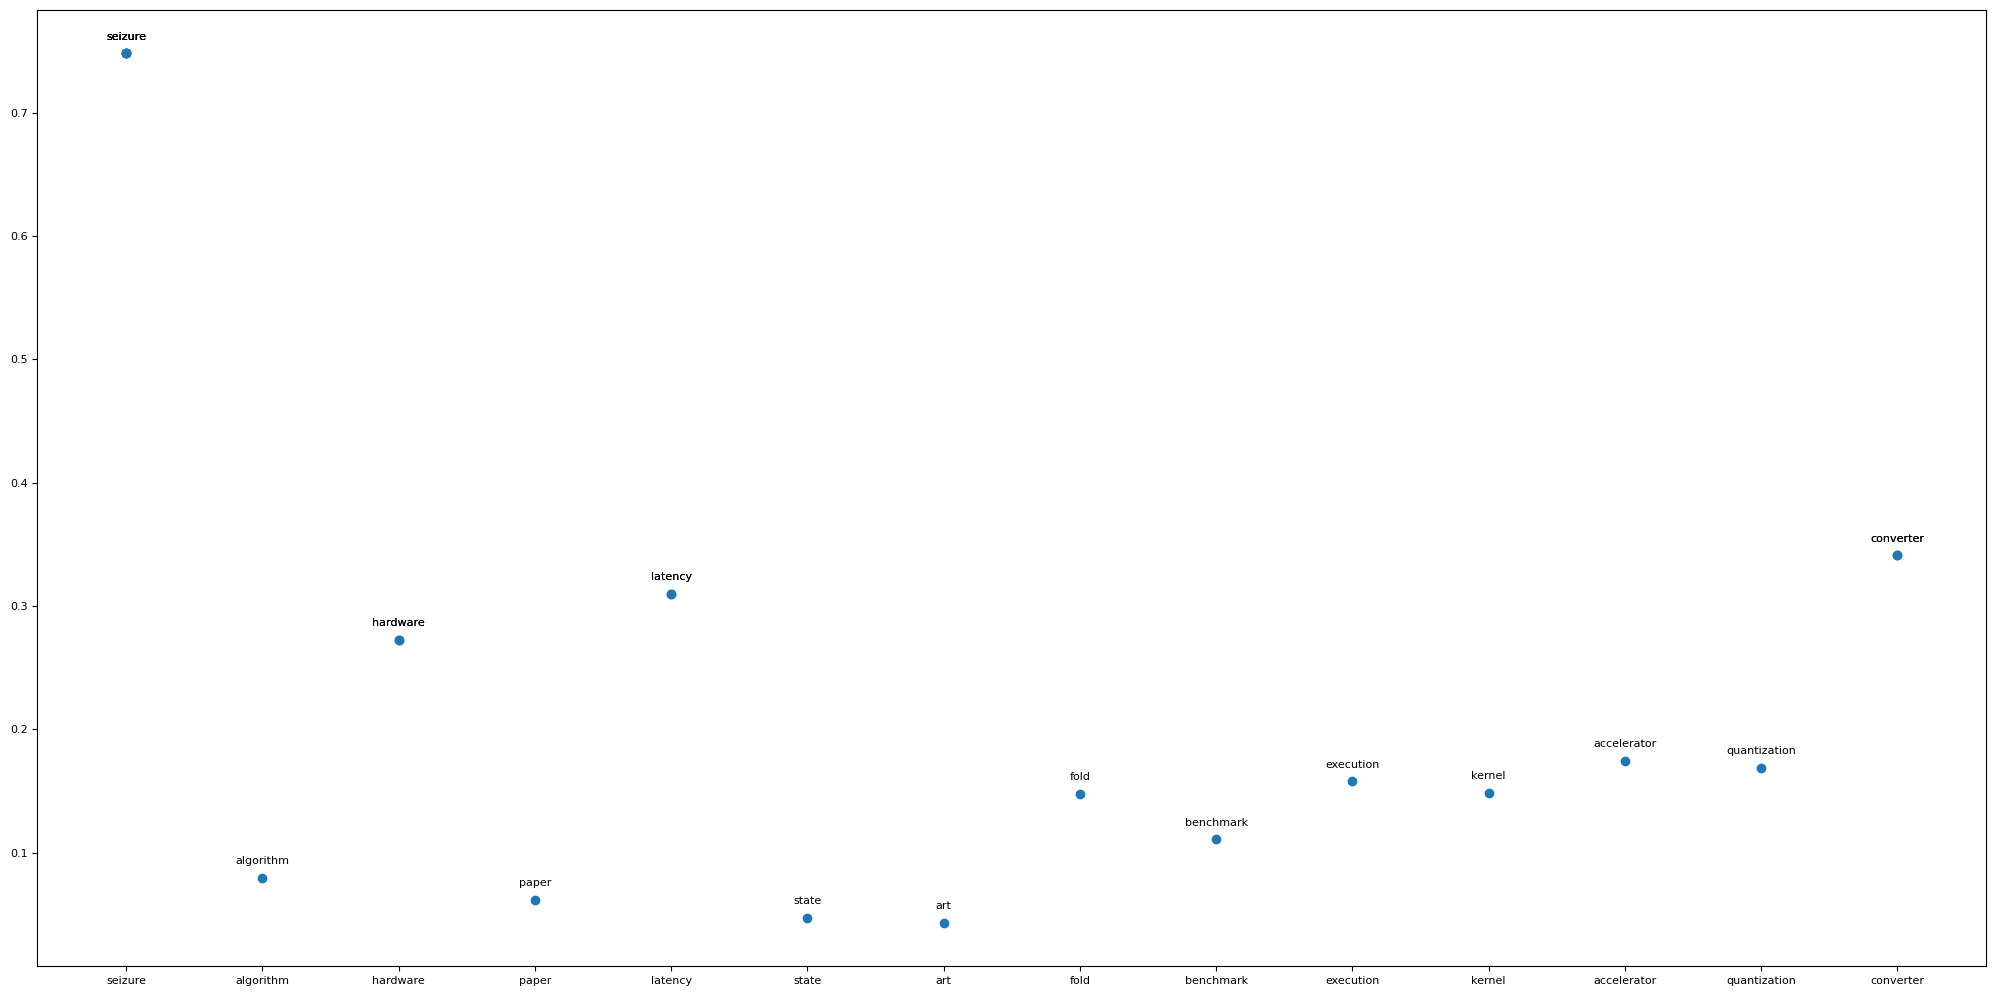

In [260]:
import matplotlib.pyplot as plt

# Index of document to vizualize TF-IDF
idx_doc = 1

plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["font.size"] = 8

doc = corpus[idx_doc]
doc = [token for token in doc if token in tfidf_matrix_df.columns]     # This is to handle - Certain tokens getting eliminated

tfidf_scores = [tfidf_matrix_df.iloc[idx_doc][token] for token in doc if token in tfidf_matrix_df.columns]
plt.scatter(doc, tfidf_scores)

labels = doc
for i, label in enumerate(labels):
    plt.annotate(label, # this is the text
                 (doc[i], tfidf_scores[i]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

In [261]:
from scipy.spatial import distance
distance.cosine([1, 0, 0], [1, 0, 0])

0

### Cosine Similarity

In [262]:
vector_1 = tfidf_matrix[2].toarray()[0]
vector_2 = tfidf_matrix[3].toarray()[0]

1-distance.cosine(vector_1, vector_2)

0.06064650412037076

In [263]:
data_df

,abstract,label,tokenized,custom_tokenized
0,Despite the use of tactile graphics and audio ...,0,"[Despite, the, use, of, tactile, graphics, and...","[graphic, audio, visually, artwork, art, exhib..."
1,"During the past two decades, epileptic seizure...",1,"[During, the, past, two, decades, ,, epileptic...","[epileptic, seizure, algorithm, hardware, area..."
2,Lymph node metastasis is one of the most impor...,1,"[Lymph, node, metastasis, is, one, of, the, mo...","[lymph, metastasis, breast, cancer, diagnosis,..."
3,In order to assess the effectiveness of the Ch...,0,"[In, order, to, assess, the, effectiveness, of...","[cohort, adult, patient, shenzhen, antiretrovi..."
4,Convolutional Neural Networks (CNNs) have beco...,0,"[Convolutional, Neural, Networks, (, CNNs, ), ...","[networks, state, art, vision, recognition, co..."
...,...,...,...,...
5995,"Phase change memory (PCM) is an emerging, resi...",0,"[Phase, change, memory, (, PCM, ), is, an, eme...","[pcm, resistance, nonvolatile, pcm, pcm, write..."
5996,Oxy-fuel combustion stands as a promising carb...,0,"[Oxy-fuel, combustion, stands, as, a, promisin...","[oxy, layout, oxy, paper, state, art, oxy, oxy..."
5997,This study aims to establish an efficient pret...,1,"[This, study, aims, to, establish, an, efficie...","[sugar, macroalgae, eucheuma, cottonii, residu..."
5998,Pseudomonas aeruginosa is an opportunistic pat...,1,"[Pseudomonas, aeruginosa, is, an, opportunisti...","[pseudomonas, aeruginosa, pathogen, acute, chr..."


#### Most similar top 10 documents

In [290]:
doc_idx = 0
vector_doc_idx = tfidf_matrix[doc_idx].toarray()[0]

cosines = [1-distance.cosine(vector_doc_idx, tfidf_matrix[i].toarray()[0]) for i in range(tfidf_matrix.shape[0])]
# cosines.sort(reverse=True)
cosines = np.array(cosines)
cosines_indices = cosines.argsort()

print("Input document:", data_df.iloc[doc_idx]['abstract'], data_df.iloc[doc_idx]['label'], "\n\n")
print("Top 5 most similar are:", "\n")

for i in range(5):
    cosines_index = cosines.argsort()[:-1*(i+1):][-1]
    print(cosines_index, cosines[cosines_index], '\n', data_df.iloc[cosines_index]['abstract'], data_df.iloc[cosines_index]['label'], "\n")

Input document: Despite the use of tactile graphics and audio guides, blind and visually impaired people still face challenges to experience and understand visual artworks independently at art exhibitions. Art museums and other art places are increasingly exploring the use of interactive guides to make their collections more accessible. In this work, we describe our approach to an interactive multimodal guide prototype that uses audio and tactile modalities to improve the autonomous access to information and experience of visual artworks. The prototype is composed of a touch-sensitive 2.5D artwork relief model that can be freely explored by touch. Users can access localized verbal descriptions and audio by performing touch gestures on the surface while listening to themed background music along. We present the design requirements derived from a formative study realized with the help of eight blind and visually impaired participants, art museum and gallery staff, and artists. We extende

In [265]:
cosines = [1-distance.cosine(vector_doc_idx, tfidf_matrix[i].toarray()[0]) for i in range(tfidf_matrix.shape[0])]
# cosines

In [266]:
cosines = np.array(cosines)
cosines.argsort()[-1]

0

In [267]:
cosines[3805]

1.0

In [4]:
# Counter(cosines)

#### Finding most similar document to the one at index 0

In [269]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities = cosine_similarity(tfidf_matrix[0], tfidf_matrix)  #here the first element of tfidf_matrix_train is matched with other three elements

In [270]:
cosine_similarities.argsort()[:-2:-1][0]

array([2872, 2971, 5870, ..., 3568, 5266,    0], dtype=int64)

In [286]:
cosine_similarities[0].argsort()[:-1:][-1]

5266

In [278]:
index = cosine_similarities[0].argsort()[:-1:][-1]

print(data_df.iloc[0]['abstract'], '\n')
print(data_df.iloc[index]['abstract'], '\n')

vector_1 = tfidf_matrix[0].toarray()[0]
vector_2 = tfidf_matrix[index].toarray()[0]

1-distance.cosine(vector_1, vector_2)

Despite the use of tactile graphics and audio guides, blind and visually impaired people still face challenges to experience and understand visual artworks independently at art exhibitions. Art museums and other art places are increasingly exploring the use of interactive guides to make their collections more accessible. In this work, we describe our approach to an interactive multimodal guide prototype that uses audio and tactile modalities to improve the autonomous access to information and experience of visual artworks. The prototype is composed of a touch-sensitive 2.5D artwork relief model that can be freely explored by touch. Users can access localized verbal descriptions and audio by performing touch gestures on the surface while listening to themed background music along. We present the design requirements derived from a formative study realized with the help of eight blind and visually impaired participants, art museum and gallery staff, and artists. We extended the formative 

0.6346847691110359

In [274]:
print(data_df.iloc[0]['label'])
print(data_df.iloc[index]['label'])

0
0


In [275]:
data_df.iloc[0]

abstract            Despite the use of tactile graphics and audio ...
label                                                               0
tokenized           [Despite, the, use, of, tactile, graphics, and...
custom_tokenized    [graphic, audio, visually, artwork, art, exhib...
Name: 0, dtype: object

## Doc2Vec

#### Training fresh Doc2Vec

In [291]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_docs)]
model = Doc2Vec(documents, vector_size=50, window=5, min_count=1, workers=4)

In [295]:
v1 = model.infer_vector([corpus_docs[0]])
v1

array([ 1.4174473e-03, -8.9625427e-03, -2.0000934e-05,  1.0751259e-03,
        8.8208104e-03,  5.2767145e-03, -1.0200418e-03,  5.3979922e-03,
       -3.1554378e-03,  8.9697801e-03,  4.0666950e-03,  2.2430718e-03,
        6.1033298e-03, -3.9058160e-03, -5.6303130e-03, -7.5947284e-04,
        3.3463144e-03, -3.8597817e-03, -4.9496191e-03, -5.6032119e-03,
       -4.3083215e-03,  7.2747353e-04, -6.9024251e-03, -3.9112759e-03,
       -1.9652664e-04,  6.1757504e-03, -9.0615368e-03,  5.8745788e-03,
        7.5711585e-03, -4.6981229e-03,  6.0070050e-03,  1.7678631e-03,
        2.0067226e-03, -6.4845379e-03, -3.3803552e-03, -9.3695400e-03,
        9.7154891e-03, -8.5899746e-03, -4.3217833e-03, -1.0685707e-03,
        8.9635300e-03,  5.9663607e-03,  8.2824985e-03, -3.1130642e-03,
        3.9974665e-03, -8.3758226e-03,  5.9612812e-03,  1.9043409e-03,
        8.3247609e-03,  1.0891723e-03], dtype=float32)

In [296]:
similar_doc = model.docvecs.most_similar([v1])
similar_doc

C:\Users\suket\AppData\Local\Temp\ipykernel_12888\4040845599.py:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_doc = model.docvecs.most_similar([v1])


[(782, 0.46988290548324585),
 (5479, 0.4618339240550995),
 (5102, 0.4441215693950653),
 (3951, 0.44386500120162964),
 (662, 0.4425056278705597),
 (1061, 0.4300258457660675),
 (4162, 0.4229282736778259),
 (2613, 0.42238548398017883),
 (3042, 0.4199299216270447),
 (4116, 0.41900599002838135)]

In [302]:
print(corpus_docs[0], '\n')

print(corpus_docs[similar_doc[0][0]], '\n')
print(corpus_docs[similar_doc[1][0]], '\n')
print(corpus_docs[similar_doc[2][0]], '\n')
print(corpus_docs[similar_doc[3][0]], '\n')
print(corpus_docs[similar_doc[4][0]], '\n')

graphic audio visually artwork art exhibition art museum art audio autonomous artwork artwork audio listen music formative visually art museum gallery artist formative art exhibition graphic artwork 

cytochrome p450 2j2 cyp2j2 expression extrahepatic tissue heart kidney tumour inhibition cyp2j2 cancer treatment metabolises arachidonic acid aa epoxyeicosatrienoic acid eet inhibits apoptosis promotes tumour growth kinase inhibitor mki molecular drug antitumor inhibitory mkis cyp2j2 mkis cyp2j2 catalyse eet formation aa twenty mkis inhibitory potency astemizole demethylation cyp2j2 apatinib motesanib vatalanib inhibit astemizole demethylation mkis inhibition inhibition ki apatinib motesanib vatalanib inhibit cyp2j2 catalyse eet formation aa dock cyp2j2 apatinib motesanib vatalanib kcal mol apatinib motesanib vatalanib inhibit cyp2j2 cyp2j2 alter administration mkis 

qianbei goat goat breed snp nucleotide polymorphism plin2 gene lamb dna qpcr plin2 protein specie expression plin2 gene go

## Pre-Trained Embeddings

https://radimrehurek.com/gensim/models/word2vec.html

https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html

### Glove

In [304]:
import gensim.downloader
from pprint import pprint

pprint(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']


In [305]:
glove_vectors = gensim.downloader.load('glove-twitter-50')

[==================================================] 100.0% 199.5/199.5MB downloaded


In [318]:
corpus[0]

['graphic',
 'audio',
 'visually',
 'artwork',
 'art',
 'exhibition',
 'art',
 'museum',
 'art',
 'audio',
 'autonomous',
 'artwork',
 'artwork',
 'audio',
 'listen',
 'music',
 'formative',
 'visually',
 'art',
 'museum',
 'gallery',
 'artist',
 'formative',
 'art',
 'exhibition',
 'graphic',
 'artwork']

In [319]:
data_df.iloc[0]['abstract']

'Despite the use of tactile graphics and audio guides, blind and visually impaired people still face challenges to experience and understand visual artworks independently at art exhibitions. Art museums and other art places are increasingly exploring the use of interactive guides to make their collections more accessible. In this work, we describe our approach to an interactive multimodal guide prototype that uses audio and tactile modalities to improve the autonomous access to information and experience of visual artworks. The prototype is composed of a touch-sensitive 2.5D artwork relief model that can be freely explored by touch. Users can access localized verbal descriptions and audio by performing touch gestures on the surface while listening to themed background music along. We present the design requirements derived from a formative study realized with the help of eight blind and visually impaired participants, art museum and gallery staff, and artists. We extended the formative

In [317]:
glove_vectors.most_similar(corpus[0])

[('photography', 0.8582636117935181),
 ('design', 0.8465836048126221),
 ('feature', 0.8416000604629517),
 ('features', 0.8292377591133118),
 ('illustration', 0.8081194758415222),
 ('creative', 0.8058083057403564),
 ('project', 0.8045302033424377),
 ('book', 0.8011758923530579),
 ('inspired', 0.8005240559577942),
 ('animation', 0.7995397448539734)]

In [331]:
glove_vectors.most_similar(corpus[3])

KeyError: "Key 'antiretroviral' not present in vocabulary"

## Fasttext

In [324]:
fasttext_vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [325]:
fasttext_vectors.most_similar(corpus[0])

[('video-art', 0.8051044940948486),
 ('art-work', 0.7685977816581726),
 ('non-art', 0.7665229439735413),
 ('art-gallery', 0.7661323547363281),
 ('public-art', 0.76341712474823),
 ('artworks', 0.7624651789665222),
 ('art-based', 0.7591071724891663),
 ('sound-art', 0.7546309232711792),
 ('visual', 0.7545879483222961),
 ('museum-going', 0.7454243898391724)]

In [329]:
corpus[3]

['cohort',
 'adult',
 'patient',
 'shenzhen',
 'antiretroviral',
 'therapy',
 'art',
 'mortality',
 'tuberculosis',
 'cell',
 'patient',
 'month',
 'art',
 'patient',
 'commenced',
 'art',
 'death',
 'tuberculosis',
 'diagnosis',
 'death',
 'tuberculosis',
 'diagnosis',
 'art',
 'art',
 'mortality',
 'ci',
 'tuberculosis',
 'ci',
 'month',
 'art',
 'cell',
 'cell',
 'ci',
 'cell',
 'art',
 'income',
 'mortality',
 'art',
 'art']

In [330]:
data_df.iloc[3]['abstract']

"In order to assess the effectiveness of the Chinese government's expanded access program, a cohort study on all adult HIV patients in Shenzhen was conducted from December 2003 to February 2014 to estimate the effects of antiretroviral therapy (ART) on mortality, tuberculosis and CD4 cell counts. Marginal structural regression models adjusted for baseline and time-varying covariates. Of the 6897 patients enrolled and followed up for a maximum of 178 months, 44.92% received ART. Among patients who commenced receiving ART during the study, there were 98 deaths and 59 new tuberculosis diagnoses, while there were 410 deaths and 201 new tuberculosis diagnoses among those without ART. ART was associated with both lower mortality (hazard ratio [HR] = 0.18; 95% confidence interval [CI] = 0.11-0.27) and the presence of tuberculosis (HR = 0.27; 95% CI = 0.19-0.37). Each month of ART was associated with an average increase in CD4 cell count of 6.52 cells/mu L (95% CI = 6.08-7.12 cells/mu L). In c

In [328]:
fasttext_vectors.most_similar(corpus[3])

[('life', 0.7136669158935547),
 ('disease', 0.699634313583374),
 ('medcine', 0.6985685229301453),
 ('treatment', 0.6952102780342102),
 ('chronic-pain', 0.6931683421134949),
 ('self-making', 0.6884339451789856),
 ('video-art', 0.6883834004402161),
 ('pathology', 0.6881184577941895),
 ('non-culture', 0.6879109144210815),
 ('therapy-related', 0.6870557069778442)]